# Восстановление золота из руды

# Введение

### Описание проекта 
Проект нацелен на подготовку прототипа модели машинного обучения для компании «Цифры», которая разрабатывает решения для эффективной работы промышленных предприятий. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
### Цель проекта
Используя данные с параметрами добычи и очистки, создать модель предсказания коэффициента восстановления золота из золотосодержащей руды.
### Описание данных
**Нам предоставлены сырые данные, выгруженные из хранилища.**   


Данные находятся в трёх файлах:
 - gold_recovery_train_new.csv — обучающая выборка;
 - gold_recovery_test_new.csv — тестовая выборка;
 - gold_recovery_full_new.csv — исходные данные.  

**Признаки:**

Технологический процесс:
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  - Xanthate — ксантогенат (промотер, или активатор флотации);
  - Sulphate — сульфат (на данном производстве сульфид натрия);
  - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
Параметры этапов:
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


**Целевые признаки:**
 - rougher.output.recovery - эффективность обогащения чернового концентрата
 - final.output.recovery - эффективность обогащения финального концентрата 

**Метрикой качества является sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).**

**Итоговая метрика рассчитывается по формуле:**

итоговое sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)

### План работы
1. [Загрузка и подготовка данных](#section_1)
2. [Исследовательский анализ данных](#section_2)  
3. [Создание модели](#section_3)  
4. [Общий вывод](#section_4)

<a id='section_1'></a>
## Загрузка и подготовка данных

Произведём загрузку необходимых библиотек.

In [1]:
# анализ данных
import pandas as pd
import numpy as np
from scipy import stats as st

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# модель машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# вспомогательные средства 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

### Загрузка исходных данных

In [2]:
try:
    train = pd.read_csv(r'D:\projects_data\gold_recovery\gold_recovery_train_new.csv').set_index('date')
    test = pd.read_csv(r'D:\projects_data\gold_recovery\gold_recovery_test_new.csv').set_index('date')
    full = pd.read_csv(r'D:\projects_data\gold_recovery\gold_recovery_full_new.csv').set_index('date')
except:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv').set_index('date')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv').set_index('date')
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv').set_index('date')

In [3]:
# настройка отображения всех столбцов и строк таблицы
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

### Проверка формулы рассчёта эффективности обогащения

Создадим функцию рассчёта эффективности восстановления золота из золотосодержащей руды. 

In [5]:
def recovery_calc(c,f,t):
    """
    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.
    """
    total_recovery = (c * (f - t)) / (f * (c - t)) * 100
    return total_recovery

In [6]:
formula_flotation_results = recovery_calc(train['rougher.output.concentrate_au'],
                                          train['rougher.input.feed_au'],
                                          train['rougher.output.tail_au'])
true_flotation_results = train['rougher.output.recovery']

In [7]:
print('MAE для флотации составляет:', mean_absolute_error(formula_flotation_results, true_flotation_results))

MAE для флотации составляет: 9.73512347450521e-15


Как мы видим, значение средней абсолютной ошибки очень близко к нулю, следовательно, использовать данную формулу рассчёта эффективности обогащения целесообразно.

### Анализ признаков тестового файла

Изучим отличия тренировочного и тестового файлов.

In [8]:
difference = set(train.columns) - set(test.columns)
difference

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В файле с тестовыми данными отсутствуют выходные параметры (output).

### Предобработка данных

#### Проверка на дубликаты

In [9]:
train.name = 'train'
test.name = 'test'
full.name = 'full'

In [10]:
for df in train,test,full:
    duplicated_sum = df.duplicated().sum().sum()
    print(f'В файле {df.name} {duplicated_sum} дубликатов')

В файле train 0 дубликатов
В файле test 0 дубликатов
В файле full 0 дубликатов


#### Проверка на пропуски

In [11]:
for df in train,test,full:
    missing_sum = df.isna().sum().sum()
    print(f'В файле {df.name} {missing_sum} пропусков, размер {df.shape}')

В файле train 4100 пропусков, размер (14149, 86)
В файле test 90 пропусков, размер (5290, 52)
В файле full 4481 пропусков, размер (19439, 86)


Так как из условия известно, что соседние по времени параметры зачастую схожи представляется целесообразным не отбрасывать строки с пропущенными значениями, а заменить их методом интерполяции.

In [12]:
train, test, full = train.interpolate(), test.interpolate(), full.interpolate()

In [13]:
train.name = 'train'
test.name = 'test'
full.name = 'full'

In [14]:
for df in train,test,full:
    missing_sum = df.isna().sum().sum()
    print(f'В файле {df.name} {missing_sum} пропусков, размер {df.shape}')

В файле train 0 пропусков, размер (14149, 86)
В файле test 0 пропусков, размер (5290, 52)
В файле full 0 пропусков, размер (19439, 86)


<a id='section_2'></a>
## Исследовательский анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Исследуем концентрации на выходах процессов очистки и в остаточных хвостах.

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

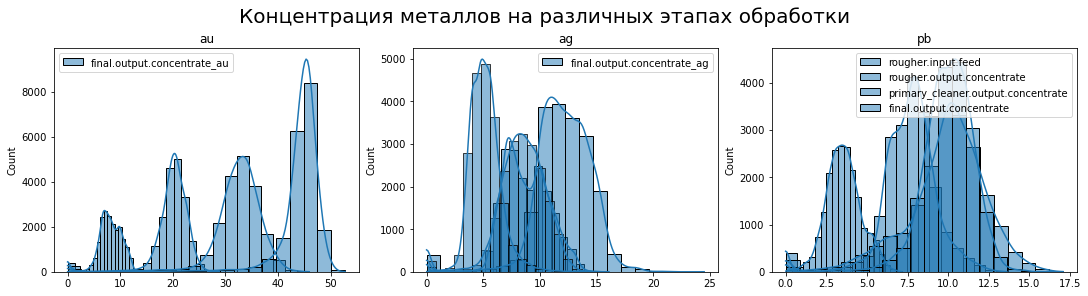

In [16]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']
metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, 3, figsize=(15,4), layout="constrained")
fig.suptitle('Концентрация металлов на различных этапах обработки', fontsize=20)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:        
        cols = full.columns.str.contains(stage+'_'+metal)
        sns.histplot(full.loc[:, cols], bins=20, label=stage, ax=ax, kde=True)
        
plt.legend()
plt.show()

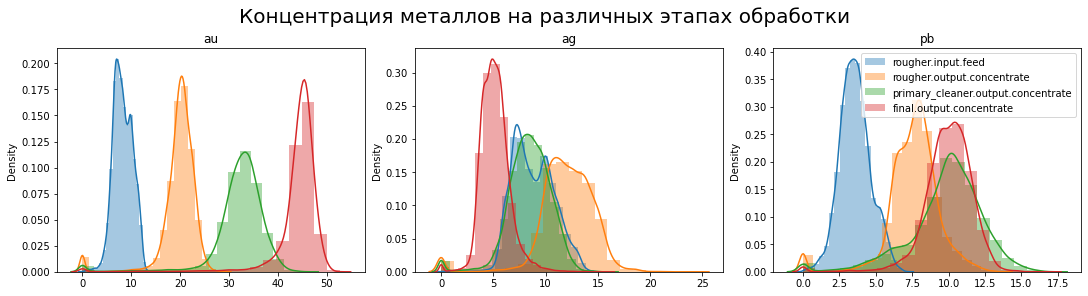

In [17]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']
metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, 3, figsize=(15,4), layout="constrained")
fig.suptitle('Концентрация металлов на различных этапах обработки', fontsize=20)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:        
        cols = full.columns.str.contains(stage+'_'+metal)
        sns.distplot(full.loc[:, cols], bins=20, label=stage, ax=ax, kde=True)
        
plt.legend()
plt.show()

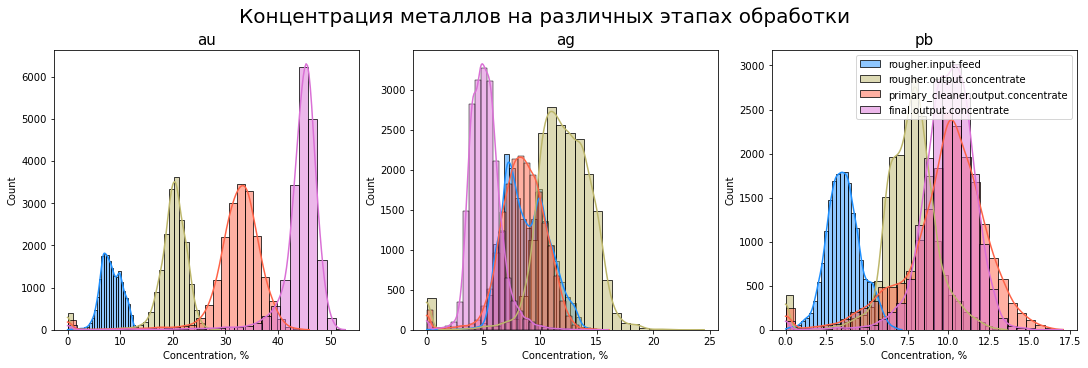

In [18]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']
colors = ['#1E90FF', '#BDB76B', '#FF6347', '#DA70D6']
metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, 3, figsize=(15,5), layout="constrained")
for metal, ax in zip(metals, axs):
    ax.set_title(metal, size=15)
    ax.set_xlabel('Concentration, %')
    for stage, color in zip(process, colors):
        sns.histplot(full[stage+'_'+metal], bins=30, color=color, label=stage, ax=ax, kde=True)
        
fig.suptitle('Концентрация металлов на различных этапах обработки', fontsize=20)
plt.legend()
plt.show()

На графиках видно увеличение относительного количества золота в концентрате.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

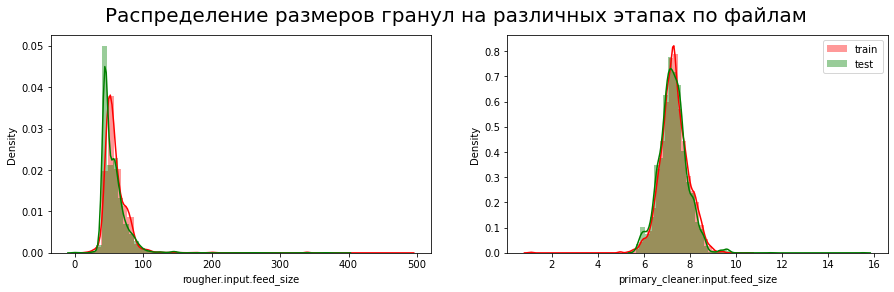

In [19]:
process = ['rougher.input.feed_size',
           'primary_cleaner.input.feed_size']
colors = ['r', 'g']

fig, axs = plt.subplots(1, 2, figsize=(15,4)) #, layout="constrained")
fig.suptitle('Распределение размеров гранул на различных этапах по файлам', fontsize=20)

for stage, ax in zip(process, axs):
    for df,color in zip([train, test], colors):        
        sns_ax = sns.distplot(df.loc[:, stage], label=df.name, color=color, ax=ax, kde=True)
plt.legend()
plt.show()

Распределения размеров гранул в тренировочном и тестовом датасете отличаются не сильно, следовательно, ошибка модели будет небольшой.

### Анализ суммарной концентрации всех веществ на разных стадиях

In [20]:
total_feed = full['rougher.input.feed_ag'] + full['rougher.input.feed_au'] + \
             full['rougher.input.feed_pb'] + full['rougher.input.feed_sol']

total_rougher_concentrate = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_au'] + \
                            full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol']

total_final_concentrate = full['final.output.concentrate_ag'] + full['final.output.concentrate_au'] + \
                          full['final.output.concentrate_pb'] + full['final.output.concentrate_sol']
total_feed.name = 'total_feed'
total_rougher_concentrate.name = 'total_rougher_concentrate'
total_final_concentrate.name = 'total_final_concentrate'

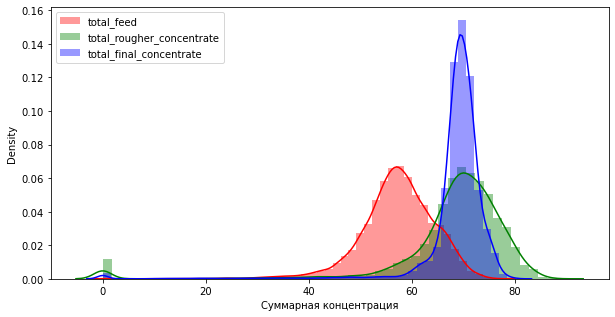

In [21]:
total_values = [total_feed, total_rougher_concentrate, total_final_concentrate]
colors = ['r', 'g', 'b']

fig, ax = plt.subplots(figsize=(10,5))
for summary, color in zip(total_values, colors):
    sns.distplot(summary, color=color, label=summary.name)
    
ax.set_xlabel('Суммарная концентрация')
plt.legend()
plt.show()

На графике видно, что концентрация веществ после прохождения всех этапов значительно увеличивается. Более узкое распределение концентрата после финального этапа говорит о том, что процесс очистки выдаёт стабильный результат. При этом наблюдаются выбросы в районе нулевого значения, которые по логике являются сбоем измерительного оборудования, либо связаны с ошибками при выгрузке данных. Следовательно, необходимо избавиться от нулевых значений в тренировочной выборке, чтобы избежать погрешностей при обучении моделей.

In [22]:
total_feed = train['rougher.input.feed_ag'] + train['rougher.input.feed_au'] + \
             train['rougher.input.feed_pb'] + train['rougher.input.feed_sol']

total_rougher_concentrate = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_au'] + \
                            train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol']

total_final_concentrate = train['final.output.concentrate_ag'] + train['final.output.concentrate_au'] + \
                          train['final.output.concentrate_pb'] + train['final.output.concentrate_sol']
total_feed.name = 'total_feed'
total_rougher_concentrate.name = 'total_rougher_concentrate'
total_final_concentrate.name = 'total_final_concentrate'

In [23]:
train = train[total_feed > 0]
train = train[total_rougher_concentrate > 0]
train = train[total_final_concentrate > 0]

C:\Users\Egor\AppData\Local\Temp\ipykernel_6588\2335936335.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = train[total_final_concentrate > 0]


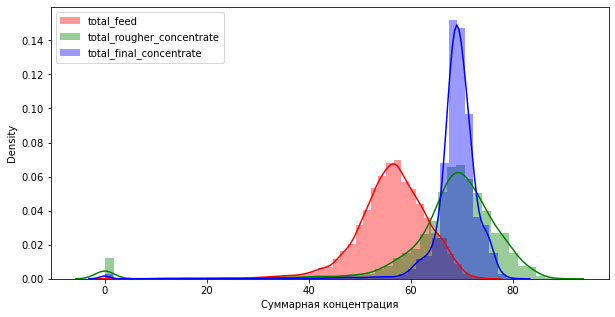

In [24]:
total_values = [total_feed, total_rougher_concentrate, total_final_concentrate]
colors = ['r', 'g', 'b']

fig, ax = plt.subplots(figsize=(10,5))
for summary, color in zip(total_values, colors):
    sns.distplot(summary, color=color, label=summary.name)
    
ax.set_xlabel('Суммарная концентрация')
plt.legend()
plt.show()

In [25]:
train.shape

(13795, 86)

<a id='section_3'></a>
## Создание модели

### Подготовка признаков

Так как в тестовой выборке отсутсвуют все выходные параметры, в обучающей выборке от них тоже необходимо избавиться.

In [26]:
y_train = train[['rougher.output.recovery', 'final.output.recovery']]
y_test = full[full.index.isin(test.index)][['rougher.output.recovery', 'final.output.recovery']]
X_train = train.drop(difference, axis=1)
X_test = test

In [27]:
feature_scaler = StandardScaler()

feature_scaler.fit(X_train)

X_train = pd.DataFrame(feature_scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test), columns=X_test.columns)

y_1_train, y_2_train = y_train['rougher.output.recovery'], y_train['final.output.recovery']
y_1_test, y_2_test = y_test['rougher.output.recovery'], y_test['final.output.recovery']

In [28]:
# проверка
X_train.shape, X_test.shape

((13795, 52), (5290, 52))

### Функция рассчёта sMAPE

Для оценки качества модели будем использовать метрику sMAPE.

In [29]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [30]:
 def total_smape_info(y_true, y_pred):
    print(f'Итоговый sMAPE: {round(0.25 * smape(y_true, y_pred)[0] + 0.75 * smape(y_true, y_pred)[1], 2)} %')

In [31]:
def total_smape(y_true, y_pred):
    rougher_smape = smape(y_true, y_pred)[0]
    final_smape = smape(y_true, y_pred)[1]
    return 0.25 * rougher_smape + 0.75 * final_smape

In [32]:
my_scorer = make_scorer(total_smape, greater_is_better=False)

### Линейная регрессия

In [33]:
lr = LinearRegression()

scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=my_scorer)
final_score = pd.Series(scores).mean()

print('Оценка модели после кросс валидации:', round(np.abs(final_score), 2))

Оценка модели после кросс валидации: 10.09


### Decision Tree

In [34]:
%%time
dt = DecisionTreeRegressor()

param_grid = {'max_depth': [int(x) for x in np.linspace(1, 25, num = 25)],
              'min_samples_split': [2,3,5,7,9],
              'min_samples_leaf': [1,3,5,7,9]}

dt_hrs = HalvingRandomSearchCV(DecisionTreeRegressor(random_state=12345), 
                                param_grid, 
                                cv=3,
                                scoring=my_scorer,
                                n_jobs=-1,
                                random_state=12345)

dt_hrs.fit(X_train, y_train)
print('Оценка модели после кросс валидации:', round(np.abs(dt_hrs.best_score_), 2))
dt_hrs.best_params_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 625 is smaller than n_iter=2299. Running 625 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Оценка модели после кросс валидации: 10.33
CPU times: total: 5.58 s
Wall time: 13 s


{'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 3}

### Random Forest

Обучим моедль RandomForestRegressor с методом подбора гиперпараметров HalvingRandomSearchCV.

In [35]:
%%time
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(1, 25, num = 25)],
              'min_samples_split': [2,3,5,7,9],
              'min_samples_leaf': [1,3,5,7,9]}

rfr_hrs = HalvingRandomSearchCV(RandomForestRegressor(random_state=12345), 
                                param_grid, 
                                cv=3, 
                                scoring=my_scorer,
                                n_jobs=-1,
                                max_resources=10000,
                                random_state=12345)

rfr_hrs.fit(X_train, y_train)
print('Оценка модели после кросс валидации:', round(np.abs(rfr_hrs.best_score_), 2))
rfr_hrs.best_params_

Оценка модели после кросс валидации: 9.52
CPU times: total: 18.1 s
Wall time: 2min 13s


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 4}

Как мы видим, модель RandomForestRegressor с методом подбора гиперпараметров HalvingRandomSearchCV продемонстрировала наилучшую оценку, следовательно, она будет использоваться для проверки на тестовой выборке.

### Проверка

In [36]:
y_pred = rfr_hrs.predict(X_test)
total_smape_info(y_test, y_pred)

Итоговый sMAPE: 8.79 %


Для проверки модели на адекватность сравним результаты модели с простейшей моделью, предсказывающей целевые признаки по средним значениям.

In [37]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
total_smape_info(y_test, y_pred)

Итоговый sMAPE: 9.82 %


На тестовой выборке модель продемонстрировала результат в 8.79 %, что на 1,03 % лучше, чем предсказание константной модели. 

<a id='section_4'></a>
## Общий вывод

В ходе исследования были обработаны и проанализированы данные с параметрами очистки золота. 
Были изучены данные о изменениии концентрации метоллов на различных этапах переработки, созданы модели предсказания содержания золота в концентрате после флотации и финальной очистки, а также сделаны выводы и рекомендации. 

**После проделанного исследования можно сделать следующие выводы:**

1. Выявленые в файлах пропуски необходимо заполнять методом интерполяции.
2. Формула рассчёта эффективности обогащения показала высокую точность. 
3. В тестовой выборке отсутсвуют данные выходных параметров каждого из этапов обработки.
4. Выявлено значительное увеличение концентрации веществ после прохождения всех этапов обработки.
5. После проведения обработки сырья доля золота увеличивается в 6 раз.
6. Создана модель, способная с погрешностью в 9% определять эффективность восстановления золота из золотосодержащей руды.

**Рекомендации:**
1. Обратить внимание на наличие аномальных значений в столбцах, связанных с концентрацией веществ.
2. Использовать итоговую модель прогнозирования эффективности обогащения золотой руды.